Marras Antoine 1A CentraleSupélec: P2022

# MINI-PROJET FENICS: Modélisation à l'aide d'équations elliptiques
## Un cas particulier des équation de helmoltz: l'équation de Scorer

#### Introduction:

Lorsqu'un vent de direction constante soufle dans une plaine et rencontre une montagne, on remarque souvent des nuages aux formes particulières en aval tels que des nuages lenticulaires.[meriem chekroum]
D'autres phénomènes similaires tels que des courants ascendants violents en aval des montagnes sont observés par les aviateurs.

L'équation de Scorer modélise de telles ondes de gravité de part et d'autre des montagnes, aussi nommées __onde de Lee__, ou __onde orographiques__

## Modélisation physique:

Dans le plan ($\vec{x}$, $\vec{z}$.) on notera w(x,z) la vitesse verticale du vent en (x,z), $u_0(z)$ vitesse horizontale initiale du vent.

On se placera dans l'approximation de __Boussinesq__. (hypothèse d'incompressibilité. (variations de température négligées)).

Le domaine est un rectangle dont la base est remplacée par un profil de montagne de hauteur $h(x)$. Aux bords, on a $w = u_0\frac{d h}{dx}$ (au contact de la montagne, conservation de la quantité de mouvement du vent), et nul sur les autres bords.

En utilisant la conservation de la quantité de mouvement, de la masse et de l'énergie dans l'approximation de Boussinesq appliquée aux équations de Navier-Stokes, on a:

$\Delta w(x,z) + l(z)² w(x,z) = 0$ avec $l(z)² = \frac{N²}{u_0²} - \frac{1}{u_0} \frac{d² u_0}{dz²} $ paramètre de Scorer. Ici on prendra $u_0(z)= u_0$ donc $l(z)² =l²= \frac{N²}{u_0²}$

et $N=\sqrt{\frac{g}{\theta} \frac{d \theta}{d z}} $ fréquence de Brunt-Väisälä, environs $N_{atmos}= 0,012 s^{−1}$ dans l'atmosphère.

## Modélisation mathématique:

### Adimensionnement:

Reprenons l'équation précédente $\Delta_x w + l² w = 0$. Elle est bien elliptique (en appliquant $b² - 4ac$, on trouve $-4 < 0$)

| Quantité | Unité |  Quantités adimensionnée |
|:--------:|:-----:|:------------------------:|
|    $w$   |  $W$  |        $w = W w^*$       |
|   $x,z$  |  $L$  | $x = Lx^* , z = L z^*$   |


En précisant les dépendances spatiales du laplacien, on a $\Delta_x = \frac{1}{L²} \Delta_{x^*} $

On a $\frac{W}{L²} \Delta_{x^*} w^* + l² W w^* = 0$,
qui devient
$\Delta_{x^*} w^* + (\frac{l}{k})²w^* = 0$ en introduisant $k=\frac{1}{l}$, en $L^{-1}$

Par la suite, on retirera les * par soucis de clarté.

### Domaine
Le domaine est physiquement un rectangle de largeur b, de longeur 2a dont la base est remplacée par un profil de montagne. Ici, on choisira une sorcière d'Agnesi (Un profil géométrique décrivant des collines), d'équation $h(x) = \frac{\gamma³}{\gamma² + x²}$ (sommet de hauteur $\gamma$).
Le domaine est donc $\Omega =\{(x,z)\in ]-a,a[\times ]0,b[ \; | \; z> h(x)\}$


### Conditions aux bords
On a les conditions aux bords: $\forall (x,y) \in \partial \Omega$

\begin{equation}
  w(x,z)=\begin{cases}
    0, & \text{si $x=-a$ ou $x=a$ ou $z =b$ }.\\
    u_0 \frac{dh}{dx}, & \text{sinon}.
  \end{cases}
\end{equation}

### Formulation variationnelle

On choisit $v\in \mathcal{H}¹_0(\Omega)$ et en supposant $w \in H¹(\Omega)$, on obtient la formulation faible suivante:
$ \int_{\Omega} {(-\nabla{w} \nabla{v} + l² w v)}= 0$

### Utilisation d'une variable aléatoire

Le paramètre de scorer l dépend de N, qui souffre d'une incertitude relative importante. Pour vérifier ses effets sur la modélisation (et ainsi voir si les prédictions demandent une faible incertitude sur la mesure) on la modélisera par une variable aléatoire  $N \hookrightarrow \mathcal{N}( N_{atmos}, 0.001)$ (valeurs typiques dans la littérature)


## Note sur les simulations

Pour obtenir un profil de sorcière d'Agnesi, <span style="color:red"> j'ai utilisé le logiciel gmsh, couplé à dolphin-converter </span> pour générer paramétriquement un mesh du domaine au dessus de la montagne.
<span style="color:red">Le script de génération de mesh est disponible en annexe.</span>
        La montagne peut être modifiée en changeant les valeurs de la section "__Paramètres de la montagne d'Agnesi__", Puis en relançant le script en annexe (s'assurer d'avoir gmsh sur son ordinateur) et en relançant enfin la simulation.

### Imports:

In [2]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as pyplot
from mshr import *
import dolfin as fn

### Paramètres de la montagne D'Agnesi:

In [15]:
gamma = 1000    # paramètre de hauteur de la montagne
height = 2.0    # coefficient multiplicateur pour rendre plus abrubte la montagne
R = 10000.0     # ordonnée du bord supérieur du domaine.
Larg = 10000    # largeur medium montagne: __/\__ (Larg correspond à __/)
nb_point_mesh = 500 # finesse du maillage

## Code Fenics

In [11]:
def get_geometry(path_to_mesh_xml = 'generated_mesh.xml', path_to_physical_region_xml = 'generated_mesh_physical_region.xml'):
    mesh = fn.Mesh(path_to_mesh_xml)
    markers = fn.MeshFunction("size_t", mesh, path_to_physical_region_xml)
    dx = fn.Measure('dx', domain=mesh, subdomain_data=markers)
    V = FunctionSpace(mesh, 'P', 1)
    
    return mesh, markers, dx, V


def simulation(u_0, N, mesh, dx, V, epsi=10**(-6), plot_w = 15, plot_h = 8):
    """
    u_0:  vitesse horizontale initiale du vent en amont de la montagne
    N:    fréquence de fréquence de Brunt-Väisälä
    mesh: le mesh sur lequel s'execute la simulation
    dx:   Les pas de discrétisation du mesh
    V:    l'espace fonctionnel asocié au mesh
    epsi: precision demandée pour éviter les erreurs d'égalité de flottants
    
    """
    
    l=N/u_0

    # -----------------------------------------------------------------------------------------------------------------
    # Conditions aux bords
    # Nullité sur tout le bord, sauf sur la montagne
    # on prend la formule de la pente de la montagne, calculable grâce à la formule explicite de la sorcière d'Agnesi
    u_D = Expression('abs(x[0]-Larg)<epsi or abs(x[0]+Larg)<epsi? 0:   x[1]>gamma*height? 0 : -2*u_0*height*gamma*gamma*x[0]/(pow( (x[0]*x[0]+ gamma*gamma) ,2))',
                     degree = 6,
                     gamma = gamma, height=height, epsi = epsi, Larg=Larg, u_0 = u_0)

    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, u_D, boundary)
    
    # -----------------------------------------------------------------------------------------------------------------
    # Problème variationnel
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Constant(0.0)
    cte = Constant(l)
    a = - dot(grad(u), grad(v))*dx + cte*cte*u*v*dx
    L = f*v*dx # 0 obligé de passer par cette astuce pour que l logiciel l'interprète comme un problème linéaire
    # -----------------------------------------------------------------------------------------------------------------

    # Calcul de la solution
    u = Function(V)
    solve(a == L, u, bc)
    # -----------------------------------------------------------------------------------------------------------------

    # Affichage
    plt.rcParams['figure.figsize'] = [plot_w, plot_h] # Pour avour une image plus grande
    # plot(mesh) # affichage du mesh sur la figure (peut être commenté)
    p = plot(u, cmap = "RdBu_r") # RdBu
    plt.title("Conditions initiales: $u_0 =$ " + str(u_0) + ". $N=$" + str(N))
    pyplot.colorbar(p)# ajout d'une barre colorée

    plt.show()

## Simulation

Si le maillage comporte beaucoup de points, vous risquez de ne voir qu'une image grise.
Si vous baissez le nombre de point, vous verrez de nouveau le maillage


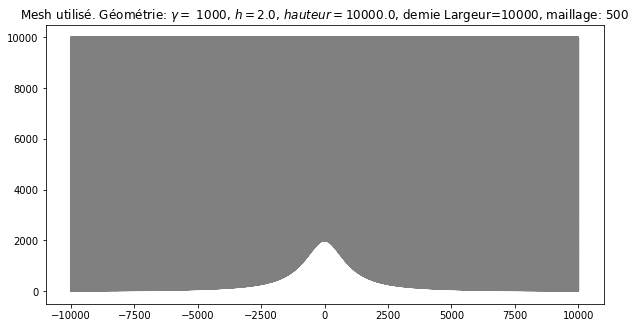

In [25]:
# Variables et paramètres nécessaires pour la simulation

seed = 2022
np.random.seed(seed) # A seed is set for reproductability

# paramètres de référence pour N
N_atm = 0.012
sigma = 0.001

# récupération de la géométrie
mesh, markers, dx, V = get_geometry() # Le charger ici evite de charger et contruire le domaine à chaque appel

u_0 = 4.4       # vent horizontal initial ici supposé uniforme

# Affichage du mesh utilisé


print("Si le maillage comporte beaucoup de points, vous risquez de ne voir qu'une image grise.\nSi vous baissez le nombre de point, vous verrez de nouveau le maillage.")

plt.title("Mesh utilisé. Géométrie: $\gamma =$ " + str(gamma) + ", $h=$" + str(height) + ", $hauteur=$" + str(R) + ", demie Largeur=" + str(Larg) + ", maillage: " + str(nb_point_mesh))
plt.rcParams['figure.figsize'] = [10, 7]
plot(mesh)
plt.show()

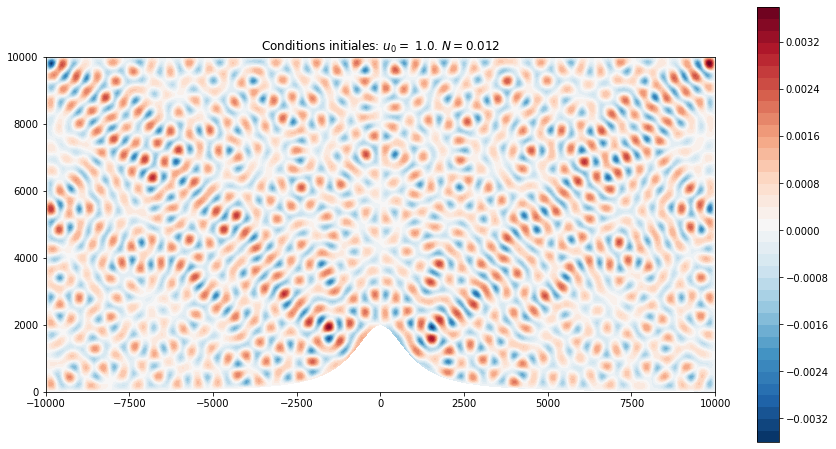

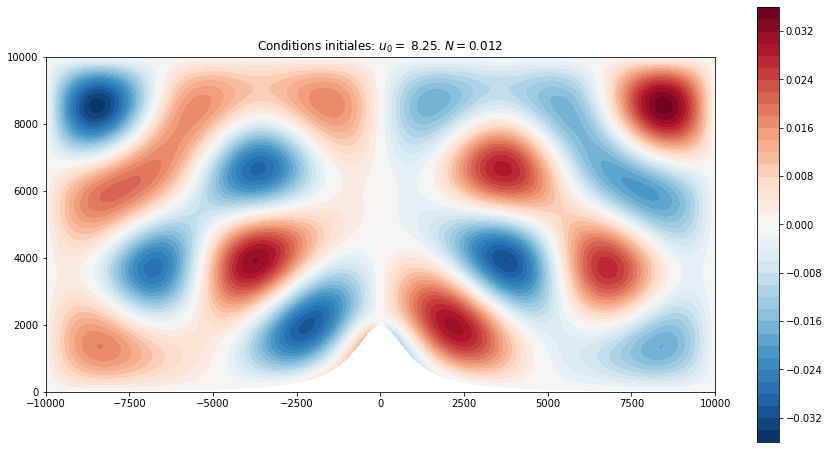

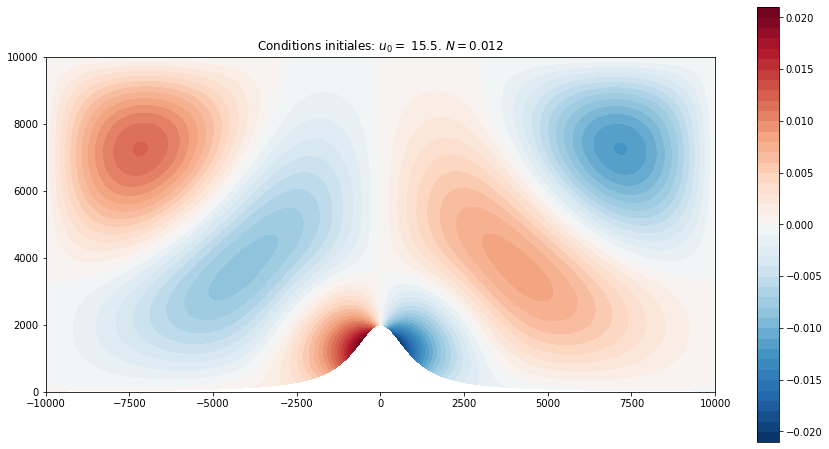

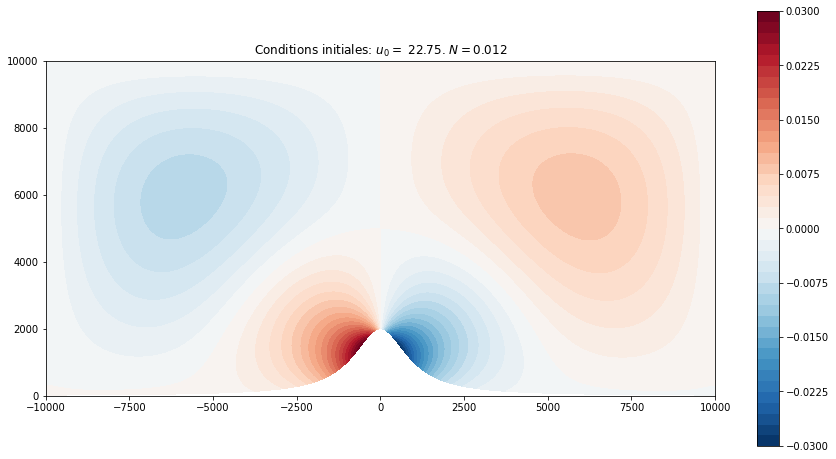

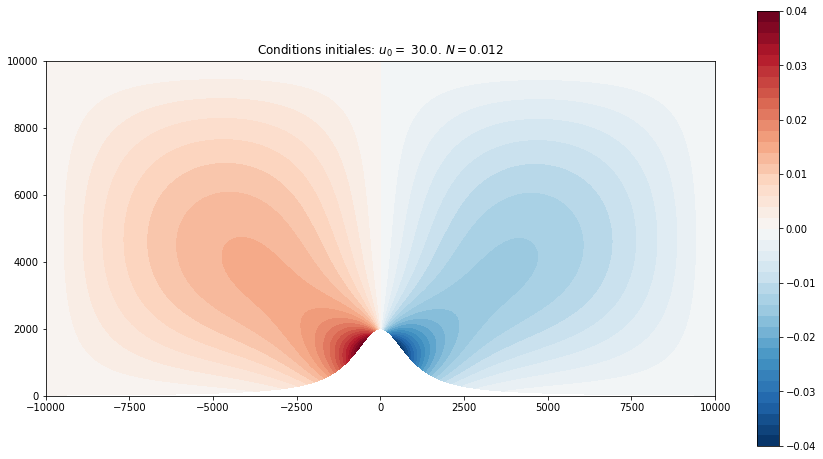

In [18]:
# Avec N constant (à N_atm), mais à u_0 variable
# But: Voir l'effet de la vitesse du vent sur les motifs de Scorer

u_min = 1  # m.s-1
u_max = 30 # m.s-1
nb_simulation = 5
u_list = np.linspace(u_min,u_max, nb_simulation)
for u in u_list:
    simulation(u_0=u, N=N_atm, mesh=mesh, dx=dx, V=V)

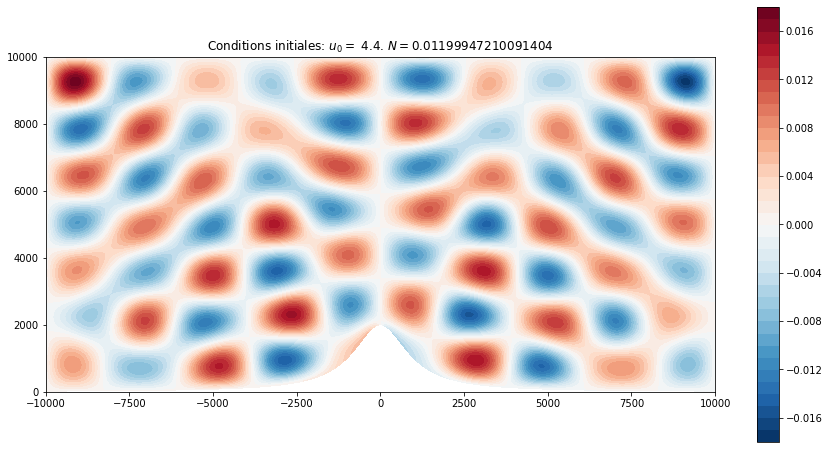

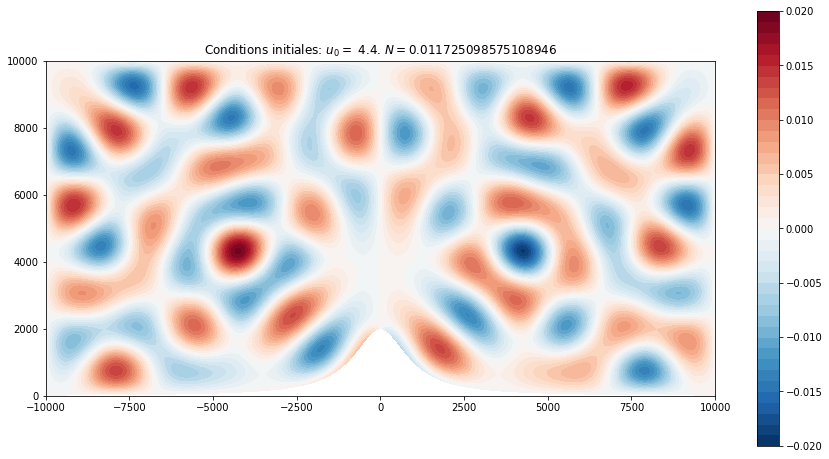

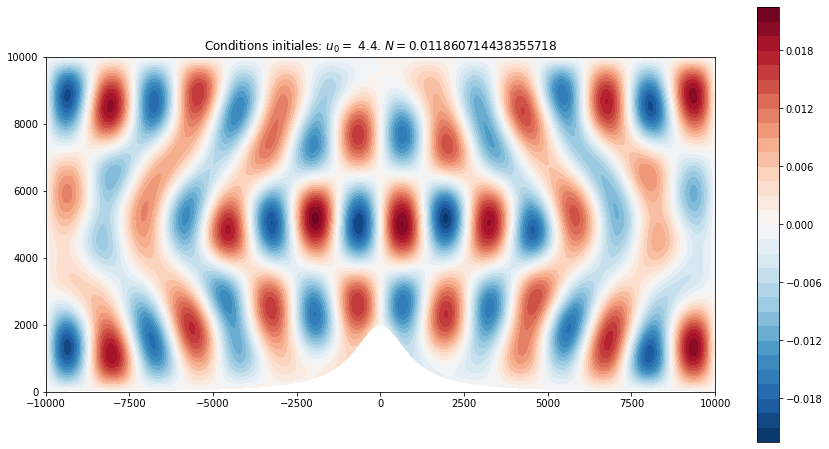

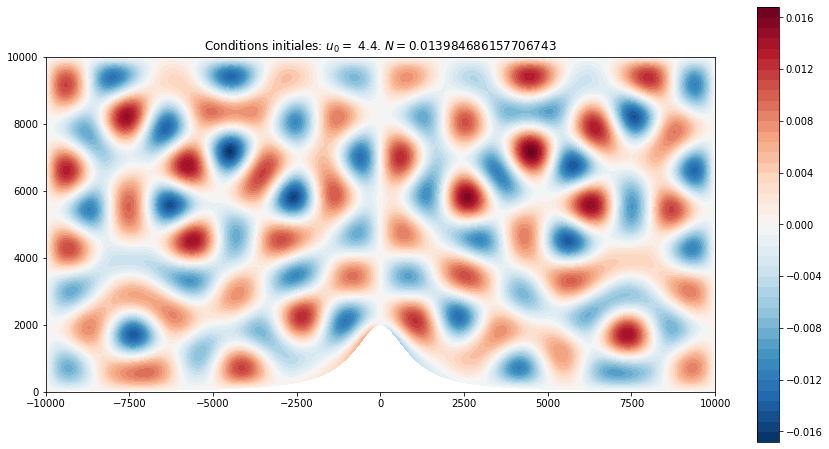

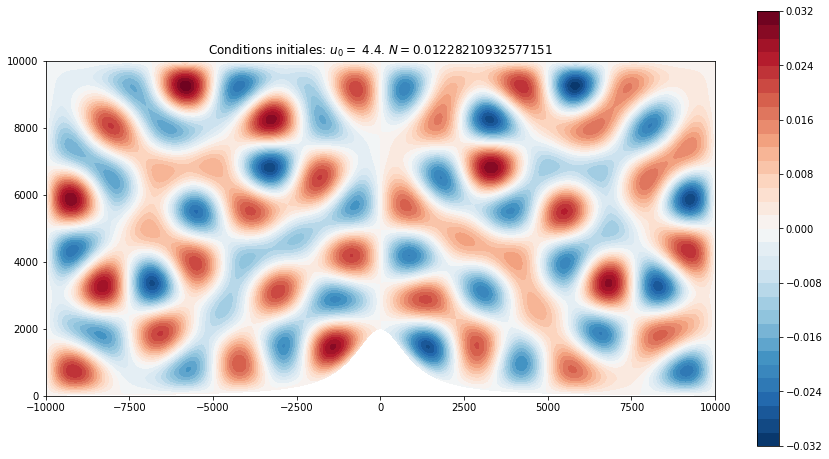

In [21]:
# A vitesse constante, mais avec N suivant une loi normale
# BUt: Voir l'effet de la variable aléatoire N

nb_simulation = 5
N_list = np.random.normal(N_atm, sigma, nb_simulation)
for N in N_list:
    simulation(u_0=u_0, N=N, mesh=mesh, dx=dx, V=V)


_Notes: les descriptions ci-dessous numérotent les simulations obtenues. Si vous avez modifiés des paramètres, veuillez revenir au valeur d'origine pour que les descriptions correspondent._

## Descriptions de simulations

La simulation fait apparaître des motifs ascendants, descendants des masses d'air en amont et en aval. On remarque une antisymétrie axiale amont-aval des perturbations. Les zones d'air ascendant (rouges) en amont ont en symétrique des zones d'air descendant bleu en aval, et réciproquement.

L'étude de l'effet de la vitesse initiale pour un N fixe montre 3 régime caractéristiques:

- A basse vitesse ($<8m.s^{-1}$), l'air est parcouru de faibles perturbations formant des alternances créant des ondelettes morcellées dont les lignes d'onde peuvent reproduire le profil de la montagne (on pourra regarder le profil de la montagne qui apparait en alternance sur les différentes couches.)

- A plus haute vitesse ($ 8<u_0<25 m.s^{-1}$), les motifs fusionnent et forment des zones convexes plus grandes formant ainsi des vortex.  

- Enfin à très haute vitesse ( $ u_0 > 25 m.s^{-1}), le phénomène de vortex cesse. On retrouve le cas classique d'un vent enveloppant une montagne, sans la formation d'onde de gravité.

L'étude de l'impact de N (variable aléatoire) à $u_0$ fixe (au $1^{er}$) régime montre la forte instabilité des motifs en fonction du paramètre N. Différents motifs apparaissent pour une variation de 0.0001 (!) tels que des ondes de chocs (3ème image), des doubles profils de montagnes (1ère image), etc

## Conclusion: 

L'étude des équations de Scorer a permis d'illustrer différents phénomènes observés empiriquement en aval des montagnes.

La simulation, en permettant de faire varier le paramètre de vitesse du vent, montre l'apparition de __motifs morcellés à basse vitesse__, pouvant provoquer des "cisaillements " (alternance haut-bas) et causant l'apparition de nuages particuliers, ou pouvant provoquer l'instabilité des véhicules volants (parapente, avion...). La simulation permet de __quantifier les maxima de variations__ et de pouvoir donner des __ordres de grandeurs__ de sécurité à respecter.

Elle montre aussi que des vortex peuvent apparaître lorsque le vent se renforce. L'intérêt de la simulation est de pouvoir quantifier un __seuil__ d'apparition de ces phénomène de vortex et de prévoir le retour à un simple "vent enveloppant" sans vortex.

Cependant, __l'ajout d'une variable aléatoire__ modélisant N montre que la forme des motifs est très sensible aux valeurs N. Le choix d'une gaussienne, maximisant l'entropie à variance fixée, nous place dans le cas le plus général possible et justifie l'importance du résultat précédent sur la sensibilité.

Il n'est donc __pas possible de prédir de façon réaliste les motifs__ apparaissant, par exemple pour prévenir un aviateur, mais il est possible de dégager des régimes types pour pouvoir planifier un survol de la montagne. 

La simulation utilise une sorcière d'Agnesi comme profil type de montagne. Les sorcières d'Agnesi sont efficaces pour représenter des collines (profil peu bombé). Mais le choix d'un facteur de dilatation permet d'étirer la montagne et rendre utilisable les résultats précédents sur des profils de montagne plus pentus. 

La simulation peut encore être affinée, notamment avec d'autres types de profils (gaussien, en aiguille) et le choix d'un vent horizontal ($u_0$) variable en fonction de l'altitude. (Le cas constant est une hypothèse simplificatrice très forte).



# Sources:

__Onde orographique et nuages lenticulaires__: Meriem Chakroun. La variabilité des nuages et son rôle sur le climat en Europe : télédétection
et simulation régionale. Océan, Atmosphère. Université Paris-Saclay, 2016. Français. �NNT :
2016SACLV067�. �tel-01599247�: page 10.

__Données et ordres de grandeurs, méthodes des ondes orographiques__ Encyclopedia of Atmospheric Sciences, 2003, Holton, J.R., J. Pyle and J.A. Curry,eds., Elsevier Science Ltd. pp. 1161-1169

__Conditions aux limites__: Theory of airflow over mountains : I11 - Airstream characteristicsBy R. S. SCORER Imperial College, London

__Utilisation de Fenics, Gmsh et dolphin-converter__: https://comphysblog.wordpress.com/2018/08/15/fenics-2d-electrostatics-with-imported-mesh-and-boundaries/




## Annexe

Template de code GMH Pour générer automatiquement la montagne


In [16]:
import os

template = """
ls = 5;
nombre_points_courbe = {0};
ratio = 1000.0; // pour convertir les mètres en kilomètres

L = {1};   // um
R = {2};   // hauteur du bord supérieur du domaine
a = {3};   // paramètre gamma de la montagne
h = {4};
Point(1) = {{-L, R, 0, ls}};
Point(2) = {{-L, 0, 0, ls}};
Point(3) = {{L, 0, 0, ls}};
Point(4) = {{L, R, 0, ls}};

Line(1) = {{1, 2}};
Line(2) = {{3, 4}};
Line(3) = {{4, 1}};

pList[0] = 2; // First point label
nPoints = nombre_points_courbe; // Nombre de points de discretisation pour la sorcière
For i In {{1 : nPoints}}
	x =-L + 2*L*i/(nPoints + 1);
	pList[i] = newp;
	Point(pList[i]) = {{x, (  h * (a * a * a)/(x*x + a*a) ) , 0, ls}};
EndFor
pList[nPoints+1] = 3; // Last point label (top-left point of the outlet region)

Spline(6) = pList[];
Line Loop(7) = {{1,6,2,3}};
Plane Surface(7) = {{7}};
Physical Surface("surf") = {{7}};
Transfinite Line {{6, 1, 3, 2}} = {5} Using Progression 1;

"""


script_msh = template.format(1000, Larg, R, gamma, height, nb_point_mesh) # nombre point courbe, L, R, a, h
print(script_msh)

with open("script.geo", "w+", encoding = "utf-8") as f:
    for ligne in script_msh:
        f.write(ligne)

# generate msh file
print("meshing...")
stream = os.popen("gmsh script.geo -2 -o ./generated_mesh.msh")
out = stream.read()
print(out)

print("convertion to xml")
# generate xml file
stream2 = os.popen("dolfin-convert generated_mesh.msh generated_mesh.xml")
out2 = stream.read()
print(out2)
print("done!!")


ls = 5;
nombre_points_courbe = 1000;
ratio = 1000.0; // pour convertir les mètres en kilomètres

L = 10000;   // um
R = 10000.0;   // hauteur du bord supérieur du domaine
a = 1000;   // paramètre gamma de la montagne
h = 2.0;
Point(1) = {-L, R, 0, ls};
Point(2) = {-L, 0, 0, ls};
Point(3) = {L, 0, 0, ls};
Point(4) = {L, R, 0, ls};

Line(1) = {1, 2};
Line(2) = {3, 4};
Line(3) = {4, 1};

pList[0] = 2; // First point label
nPoints = nombre_points_courbe; // Nombre de points de discretisation pour la sorcière
For i In {1 : nPoints}
	x =-L + 2*L*i/(nPoints + 1);
	pList[i] = newp;
	Point(pList[i]) = {x, (  h * (a * a * a)/(x*x + a*a) ) , 0, ls};
EndFor
pList[nPoints+1] = 3; // Last point label (top-left point of the outlet region)

Spline(6) = pList[];
Line Loop(7) = {1,6,2,3};
Plane Surface(7) = {7};
Physical Surface("surf") = {7};
Transfinite Line {6, 1, 3, 2} = 500 Using Progression 1;


meshing...
Info    : Running 'gmsh script.geo -2 -o ./generated_mesh.msh' [Gmsh 3.0.6, 1 node, max. 1 